# Testing the Integrated Simulation Platform
This notebook contains codes to test the various functionalities of the integrated simulation platform. You can call any of the modules from the package here. 

In [1]:
#Go to the main directory
#!pip install --editable .
#!pip install pandas
# !pip install wntr
# !pip install pandapower
# !pip install sklearn

#to find requirements
#depfinder -y .

In [2]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Import required packages

In [3]:
from pathlib import Path
from dreaminsg_integrated_model.src.network_recovery import *
import dreaminsg_integrated_model.src.simulation as simulation
from dreaminsg_integrated_model.src.network_sim_models.integrated_network import *

from dreaminsg_integrated_model.src.network_sim_models.interdependencies import *

from dreaminsg_integrated_model.src.optimizer import *
import dreaminsg_integrated_model.src.plots as model_plots

## Create an IntegratedNetwork object

In [4]:
simple_network = IntegratedNetwork()

### Load the three infrastructure models: Water, Power and Transportation

Three different models are used:
- Water distribution network using **wntr** package
- Power systems using **pandapower** package
- Transportation network using static traffic assignment package developed by Dr. Stephen Boyles (University of Texas at Austin)

In [5]:
MAIN_DIR = Path('..')

# network_dir= 'micropolis'
# water_file = MAIN_DIR/f'dreaminsg_integrated_model/data/networks/{network_dir}/water/micropolis_novalves.inp'
# power_file = MAIN_DIR/f'dreaminsg_integrated_model/data/networks/{network_dir}/power/micropolis_power.json'
# transp_folder = MAIN_DIR/f'dreaminsg_integrated_model/data/networks/{network_dir}/transportation/'

network_dir= 'in2'
water_file = MAIN_DIR/f'dreaminsg_integrated_model/data/networks/{network_dir}/water/Example_water2.inp'
power_file = MAIN_DIR/f'dreaminsg_integrated_model/data/networks/{network_dir}/power/Example_power.json'
transp_folder = MAIN_DIR/f'dreaminsg_integrated_model/data/networks/{network_dir}/transportation/'

# load all infrastructure networks
simple_network.load_networks(water_file, power_file, transp_folder)

Water network successfully loaded from ..\dreaminsg_integrated_model\data\networks\in2\water\Example_water2.inp. The analysis type is set to Pressure Dependent Demand Analysis.
initial simulation duration: 60s; hydraulic time step: 60s; pattern time step: 3600s

Power system successfully loaded from ..\dreaminsg_integrated_model\data\networks\in2\power\Example_power.json

Transportation network successfully loaded from ..\dreaminsg_integrated_model\data\networks\in2\transportation. Static traffic assignment method will be used to calculate travel times.


### Create a Networkx graph of the integrated infrastructure network.

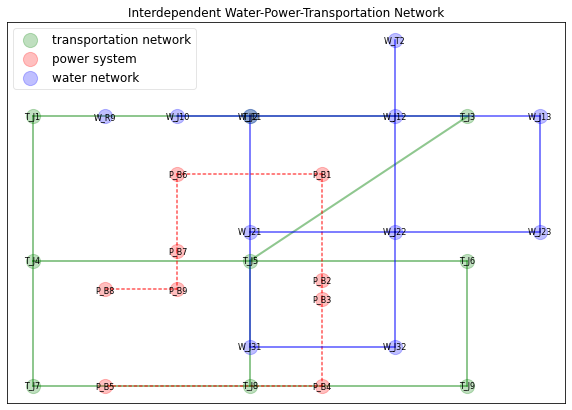

In [6]:
simple_network.generate_integrated_graph(plotting = True)

### Build interdependencies

Three types of dependencies:
- Power - Water dependencies (eg.: water pump on electric motor, generator on reservoir)
- Power - Transportation dependencies (eg.: road access to power system components for M&R)
- Water - Transportation dependencies (eg.: road access to water network components for M&R)

The dependencies are referenced using two tables in the model.
- **wp_table** for water - power dependencies
- **access_table** for transportation dependencies

In [7]:
dependency_file = MAIN_DIR/f"dreaminsg_integrated_model/data/networks/{network_dir}/dependecies.csv"
simple_network.generate_dependency_table(dependency_file = dependency_file)
simple_network.dependency_table.wp_table

,water_id,power_id,water_type,power_type
0,W_WP9,P_MP1,Pump,Motor
1,W_R9,P_G3,Reservoir,Generator


In [8]:
simple_network.dependency_table.access_table.head()

,origin_id,transp_id,origin_cat,origin_type,access_dist
0,P_B8,T_J4,power,Bus,125.00
1,P_B7,T_J5,power,Bus,103.08
2,P_B5,T_J7,power,Bus,100.00
3,P_B4,T_J8,power,Bus,100.00
4,P_B6,T_J2,power,Bus,180.28


### Set failed components

In [9]:
#scenario_file = MAIN_DIR/"dreaminsg_integrated_model/data/disruptive_scenarios/micropolis/micropolis_disruptions.csv"
scenario_file = MAIN_DIR/"dreaminsg_integrated_model/data/disruptive_scenarios/{}/{}.csv".format('test1', 'motor_failure_net1')

simple_network.set_disrupted_components(scenario_file=scenario_file)

In [10]:
simple_network.pipe_leak_node_generator()

### Set initial crew locations

In [11]:
simple_network.set_init_crew_locs(init_power_loc='T_J8',
init_water_loc='T_J8', init_transpo_loc='T_J8')

## Simulation of interdependent effects using a test scenario
### (a) Create NetworkRecovery and Optimizer objects

In [12]:
network_recovery = NetworkRecovery(simple_network, sim_step=60)
bf_optimizer = BruteForceOptimizer(prediction_horizon = 1)

### (b) Create a simulation object

In [13]:
sim_step = (
    simple_network.wn.options.time.hydraulic_timestep
)  # initial_sim_step which will be updated during the simulation
bf_simulation = simulation.NetworkSimulation(network_recovery, sim_step)

### (c) Optimization of repair strategy

In [14]:
bf_optimizer.find_optimal_recovery(bf_simulation)

PREDICTION HORIZON 1
**************************************************
Components to repair:  ['P_MP1', 'T_L2', 'W_P10', 'W_WP9'] Components repaired:  []
Repair orders under consideration in the current prediction horizon:  [['P_MP1'], ['T_L2'], ['W_P10'], ['W_WP9']]
--------------------------------------------------
Simulating the current cumulative repair order ['P_MP1'] ...
Iteration 1: gap 4642.279088: time 0.000996
Iteration 2: gap 0.000936: time 0.003988
Iteration 3: gap 0.000000: time 0.007978


ValueError: The name provided for the control is already used. Please either remove the control with that name first or use a different name for this control.

### Plot the direct and interdependent effects

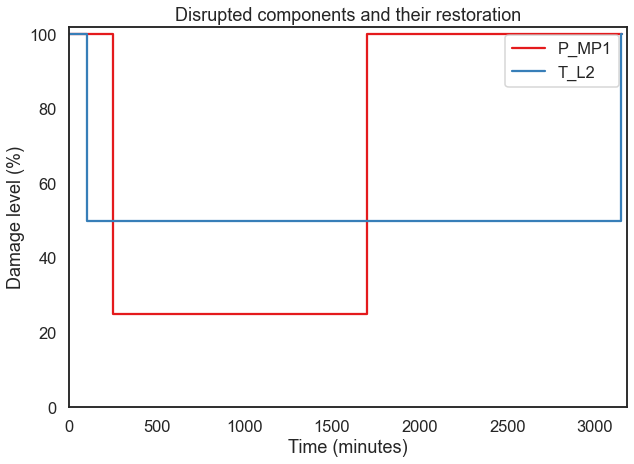

In [54]:
#Plotting repair curves
model_plots.plot_repair_curves(network_recovery, scatter = False)

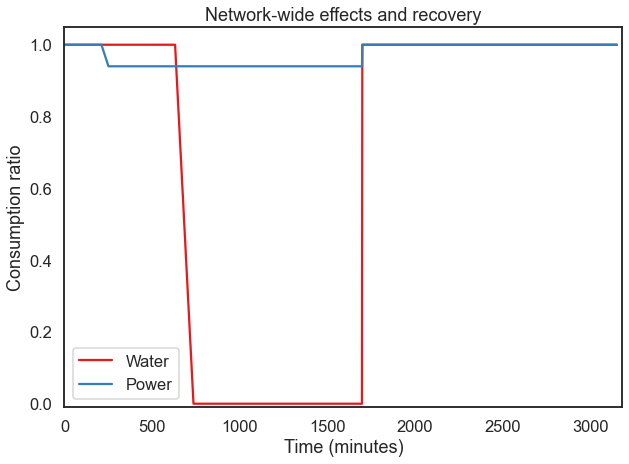

In [55]:
time_tracker, power_consump_tracker, water_consump_tracker = bf_optimizer.get_trackers()
model_plots.plot_interdependent_effects(
        power_consump_tracker,
        water_consump_tracker,
        time_tracker,
        scatter=False,
    )

In [40]:
time_tracker, power_consump_tracker, water_consump_tracker = bf_optimizer.get_trackers()

location = MAIN_DIR/"dreaminsg_integrated_model/data/disruptive_scenarios/test1"
bf_simulation.write_results(
    time_tracker, power_consump_tracker, water_consump_tracker, location, plotting=False
)

The simulation results successfully saved to ..\dreaminsg_integrated_model\data\disruptive_scenarios\test1
